In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']="/content"

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMClassifier,LGBMRegressor,callback
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 70.8MB/s]


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import zipfile
file_path='/content/house-prices-advanced-regression-techniques.zip'

with zipfile.ZipFile(file_path,'r') as zip_ref:
  zip_ref.extractall('/content/houseprices')

In [ ]:
train=pd.read_csv('/content/houseprices/train.csv')

In [ ]:
train.shape
#train.info()

(1460, 81)

In [ ]:
# Columns which have more than 50% data missing
[k for k,v in dict(train.isna().mean()).items() if v >=0.5]

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [ ]:
train=train.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'],axis =1)

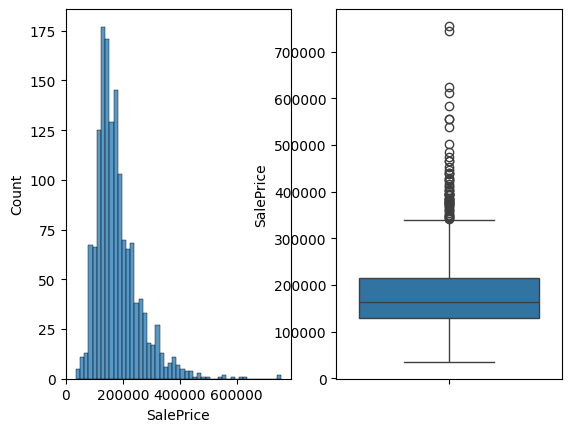

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax=plt.subplots(1,2)
sns.histplot(train['SalePrice'],ax=ax[0])
sns.boxplot(train['SalePrice'],ax=ax[1])
plt.show();

In [ ]:
#!pip install sweetviz
import sweetviz as sw

In [ ]:
# Outliers  95th Pecentile is 100 and max is 10000000
# correlations
# categorical variable correlations
# Most frequent values

In [ ]:
feature_config = sw.FeatureConfig(skip="Id")#, force_text=["Age"])
my_report=sw.analyze(train,target_feat='SalePrice',feat_cfg=feature_config)
my_report.show_html('/content/housing_eda.html')

                                             |          | [  0%]   00:00 -> (? left)

Report /content/housing_eda.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
from scipy.stats import f_oneway
from math import nan

cats=train.select_dtypes(include="O")
train2=train.copy()
for i in cats:
  train2[i]=train2[i].fillna(train2[i].mode()[0])
  groups=[]
  for cat in train2[i].unique():
      groups.append(train2[train2[i]==cat]['SalePrice'])

  fstat, pvalues=f_oneway(*groups)
  anova_vals[i]=fstat

anova_vals= {k:v for k,v in anova_vals.items() if np.isnan(v)==False}
anova_vals_value = dict(sorted(anova_vals.items(),key=lambda item:item[1],reverse=True))

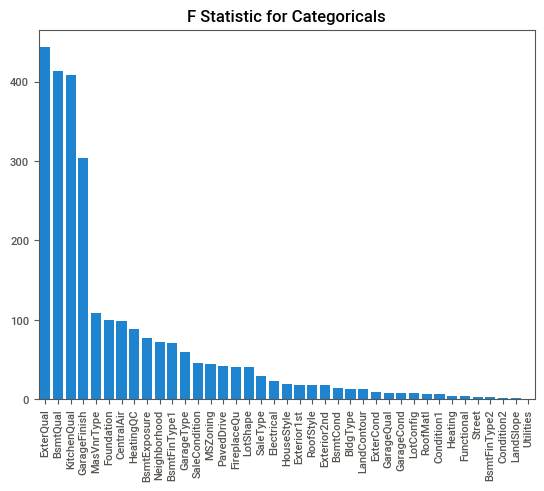

In [ ]:
sns.barplot(x=anova_vals_value.keys(),y=anova_vals_value.values())
plt.xticks(rotation=90)
plt.title("F Statistic for Categoricals")
plt.show();

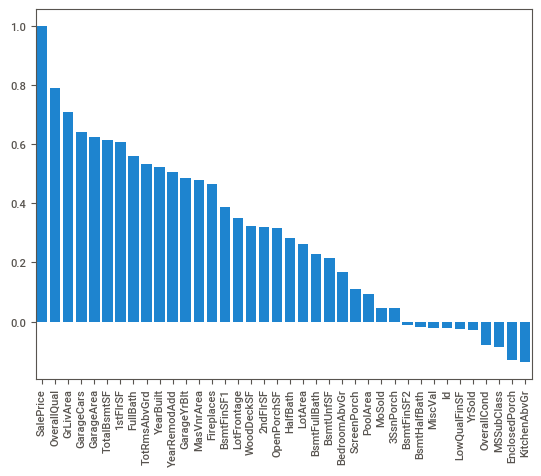

In [ ]:
sns.barplot(x=dict(sorted(dict(train.corr()['SalePrice']).items(),key=lambda item:item[1],reverse=True)).keys(),y=dict(sorted(dict(train.corr()['SalePrice']).items(),key=lambda item:item[1],reverse=True)).values())
plt.xticks(rotation=90)
plt.show();

In [ ]:
train2=pd.get_dummies(train2,columns=list(cats))

In [ ]:
nums=train2.select_dtypes(include=["int64","float64"]).columns
for i in nums:
  train2[i]=train2[i].fillna(train2[i].mean())

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
X=train2.drop(['SalePrice','Id'],axis=1)
y=train2['SalePrice']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30, random_state=42)

In [ ]:
def get_lasso_vars(alphas,X,y):
  '''
  Takes in a list of alphas. Outputs a dataframe containing the coefficients of lasso regressions from each alpha.
  '''
  # Create an empty data frame
  df=pd.DataFrame()

  # Create a column of feature names
  df['Feature Name'] = X.columns

  # For each alpha value in the list of alpha values,
  for alpha in alphas:
      # Create a lasso regression with that alpha value,
      lasso = Lasso(alpha=alpha)

      # Fit the lasso regression
      lasso.fit(X,y)

      # Create a column name for that alpha value
      column_name = 'Alpha = %f' % alpha

      # Create a column of coefficient values
      df[column_name] = lasso.coef_

  # Return the datafram
  return df

In [ ]:
features_lass=get_lasso_vars([20,30,100,200,300,550,600,800,1000],X_train,y_train)

In [ ]:
for i in features_lass.columns[1:]:
  print(i,len(features_lass[features_lass[i]!=0]))

Alpha = 20.000000 182
Alpha = 30.000000 169
Alpha = 100.000000 113
Alpha = 200.000000 88
Alpha = 300.000000 74
Alpha = 550.000000 57
Alpha = 600.000000 55
Alpha = 800.000000 42
Alpha = 1000.000000 38


In [ ]:
estimator = LinearRegression()

rfe=RFE(estimator,n_features_to_select=45,step=10)

rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=45, step=10)

In [ ]:
rfe_selection=pd.DataFrame({'feature_name':X_train.columns,
              'rfe_ranking':rfe.ranking_,
              'rfe_support':rfe.support_}).sort_values(by='rfe_ranking')

In [ ]:
def get_model_stats(cols):
  lr = LinearRegression()
  lr.fit(X_train[cols],y_train)

  y_pred=lr.predict(X_train[cols])
  y_pred_test= lr.predict(X_test[cols])

  r2_train= r2_score(y_train,y_pred)
  mse_train=mean_squared_error(y_train,y_pred)

  r2_test=r2_score(y_test,y_pred_test)
  mse_test=mean_squared_error(y_test,y_pred_test)

  return {'r2_train':r2_train,'r2_test':r2_test,'mse_train':mse_train,'mse_test':mse_test,'columns':len(cols)}#,'features':cols}

In [ ]:
# RFE selection performance
get_model_stats(list(rfe_selection[rfe_selection.rfe_ranking==1]['feature_name']))

{'r2_train': 0.7639136913471425,
 'r2_test': -1.2467780094882596e+16,
 'mse_train': 1420903265.5678644,
 'mse_test': 8.700133849286353e+25,
 'columns': 45}

In [ ]:
# Lasso selection performance
#len(features_lass[features_lass['Alpha = 550.000000']!=0]['Feature Name'])
get_model_stats(list(features_lass[features_lass['Alpha = 550.000000']!=0]['Feature Name']))

{'r2_train': 0.8747446250652757,
 'r2_test': 0.8682505140321273,
 'mse_train': 753858926.8061854,
 'mse_test': 919360266.0393733,
 'columns': 57}

In [ ]:
# Run rfe on 57 variables selected by lasso
estimator = LinearRegression()
vars=list(features_lass[features_lass['Alpha = 550.000000']!=0]['Feature Name'])
rfe=RFE(estimator,n_features_to_select=15,step=5)

rfe.fit(X_train[vars],y_train)

RFE(estimator=LinearRegression(), n_features_to_select=15, step=5)

In [ ]:
rfe_selection2=pd.DataFrame({'feature_name':X_train[vars].columns,
              'rfe_ranking':rfe.ranking_,
              'rfe_support':rfe.support_}).sort_values(by='rfe_ranking')

In [ ]:
r2_test1=[]
r2_train1=[]
mse_train1=[]
mse_test1=[]
num_vars1=[]
var_names1=[]
ranking=[]
for i in range(1,11):
  vars=list(rfe_selection2[rfe_selection2.rfe_ranking<=i]['feature_name'])
  lr = LinearRegression()
  lr.fit(X_train[vars],y_train)

  y_pred=lr.predict(X_train[vars])
  y_pred_test= lr.predict(X_test[vars])

  r2_train= r2_score(y_train,y_pred)
  mse_train=mean_squared_error(y_train,y_pred)

  r2_test=r2_score(y_test,y_pred_test)
  mse_test=mean_squared_error(y_test,y_pred_test)

  r2_test1.append(r2_test)
  r2_train1.append(r2_train)
  mse_train1.append(mse_train)
  mse_test1.append(mse_test)
  num_vars1.append(len(vars))
  var_names1.append(vars)
  ranking.append(i)

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

In [ ]:
final_list_df=pd.DataFrame({
    'r2_test':r2_test1,
'r2_train':r2_train1,
'mse_train':mse_train1,
'mse_test':mse_test1,
'num_vars':num_vars1,
'var_names':var_names1,
'ranking':ranking
}).sort_values(by=['mse_test'])

final_list_df

,r2_test,r2_train,mse_train,mse_test,num_vars,var_names,ranking
6,0.870196,0.869974,7.825720e+08,9.057849e+08,42,"[SaleCondition_Partial, Neighborhood_Crawfor, ...",7
8,0.868257,0.871881,7.710968e+08,9.193142e+08,52,"[SaleCondition_Partial, Neighborhood_Crawfor, ...",9
9,0.868251,0.874745,7.538589e+08,9.193603e+08,57,"[SaleCondition_Partial, Neighborhood_Crawfor, ...",10
7,0.867553,0.871560,7.730259e+08,9.242279e+08,47,"[SaleCondition_Partial, Neighborhood_Crawfor, ...",8
5,0.845497,0.854428,8.761344e+08,1.078137e+09,37,"[SaleCondition_Partial, Neighborhood_Crawfor, ...",6
4,0.843557,0.844943,9.332209e+08,1.091674e+09,32,"[SaleCondition_Partial, Neighborhood_Crawfor, ...",5
3,0.843007,0.842751,9.464122e+08,1.095510e+09,27,"[SaleCondition_Partial, Neighborhood_Crawfor, ...",4
2,0.837634,0.833618,1.001383e+09,1.133004e+09,22,"[SaleCondition_Partial, Neighborhood_Crawfor, ...",3
0,0.811175,0.796005,1.227757e+09,1.317639e+09,15,"[SaleCondition_Partial, Neighborhood_Crawfor, ...",1
1,0.808960,0.797246,1.220290e+09,1.333098e+09,17,"[SaleCondition_Partial, Neighborhood_Crawfor, ...",2


In [ ]:
final_list= list(rfe_selection2[rfe_selection2.rfe_ranking<=7]['feature_name'])
len(final_list)

42

In [ ]:
len(vars)

38

In [ ]:
vars=final_list
lr = LinearRegression()

from sklearn.preprocessing import StandardScaler

y_train=np.log(y_train)
y_test= np.log(y_test)

scaler=StandardScaler()
X_train=pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test=pd.DataFrame(scaler.transform(X_test),columns=X_train.columns)

lr.fit(X_train[vars],y_train)

y_pred=lr.predict(X_train[vars])
y_pred_test= lr.predict(X_test[vars])

r2_train= r2_score(y_train,y_pred)
mse_train=mean_squared_error(y_train,y_pred)

r2_test=r2_score(y_test,y_pred_test)
mse_test=mean_squared_error(y_test,y_pred_test)

r2_train
r2_test
mse_train
mse_test

LinearRegression()

0.8901613313059926

0.8816215722499574

0.017025613931143102

0.020082446285790995

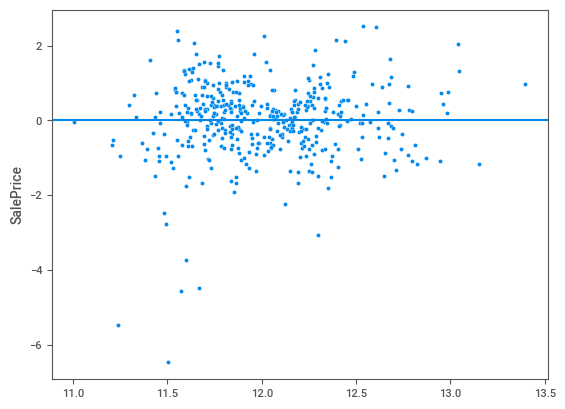

In [ ]:
residual_train = y_train- y_pred
residual_test=y_test - y_pred_test


stan_res_train=residual_train/np.std(residual_train)
stan_res_test=residual_test/np.std(residual_test)

sns.scatterplot(x=y_pred_test,y=stan_res_test)
plt.axhline(y=0)
plt.show();

<Axes: xlabel='SalePrice', ylabel='Count'>

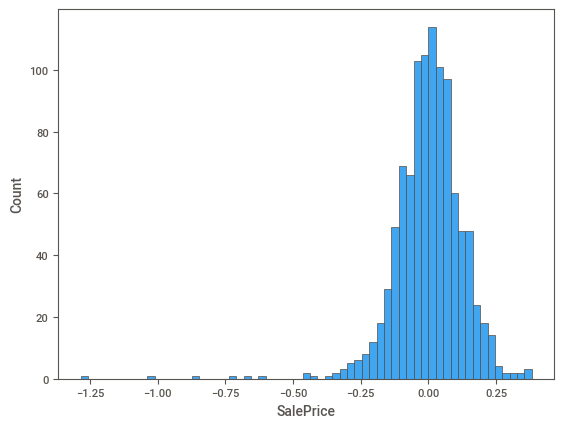

In [ ]:
sns.histplot(residual_train)

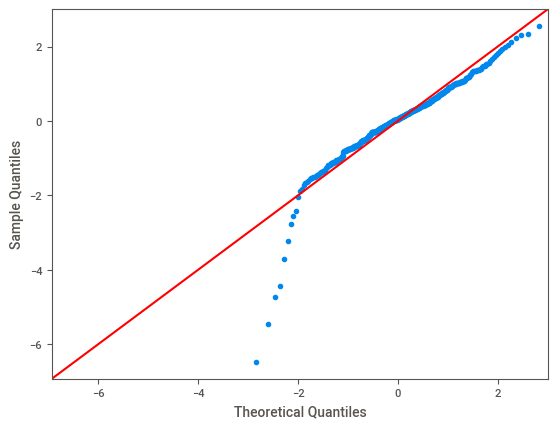

In [ ]:
import statsmodels.api as sm
sm.qqplot(stan_res_test,line='45')
plt.show();

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#vars.remove('GarageYrBlt')
#vars.remove('YearRemodAdd')
#vars.remove('TotRmsAbvGrd')
#vars.remove('YearBuilt')
 # VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train[vars].columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train[vars].values, i)
                          for i in range(len(X_train[vars].columns))]

In [ ]:
vif_data.sort_values(by='VIF',ascending=False)

,feature,VIF
41,GrLivArea,6.246224
35,YearBuilt,4.989371
21,TotRmsAbvGrd,4.931106
25,MasVnrType_None,4.035813
12,OverallQual,3.685041
32,MasVnrType_BrkFace,3.473111
40,GarageYrBlt,3.264740
39,YearRemodAdd,2.825590
15,ExterQual_TA,2.704108
36,BedroomAbvGr,2.667215


In [ ]:
vars=keep_vals
X_sm=sm.add_constant(X_train[vars])
X_sm_test=sm.add_constant(X_test[vars])

olm=sm.OLS(y_train.values,X_sm)

results=olm.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     247.2
Date:                Fri, 22 Mar 2024   Prob (F-statistic):               0.00
Time:                        02:28:12   Log-Likelihood:                 625.22
No. Observations:                1022   AIC:                            -1184.
Df Residuals:                     989   BIC:                            -1022.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    12.02

In [ ]:
keep_vals=results.params[results.pvalues<0.1]
keep_vals=list(keep_vals.index)
keep_vals.remove('const')

In [ ]:
keep_vals

['SaleCondition_Partial',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_StoneBr',
 'GarageCars',
 'FullBath',
 'MSZoning_RM',
 'Exterior1st_BrkFace',
 'BsmtQual_Ex',
 'LandContour_Bnk',
 'OverallQual',
 'BsmtExposure_Gd',
 'Condition1_Norm',
 'Fireplaces',
 'BsmtFullBath',
 'BsmtFinType1_Unf',
 'TotRmsAbvGrd',
 'OverallCond',
 'Functional_Typ',
 'HeatingQC_Ex',
 'BsmtExposure_No',
 'GarageType_Attchd',
 'MSSubClass',
 'LotFrontage',
 'YearBuilt',
 'BedroomAbvGr',
 'ScreenPorch',
 '3SsnPorch',
 'YearRemodAdd',
 'GrLivArea']

In [ ]:
lr=LinearRegression()
lr.fit(X_train[vars],y_train)

y_pred=lr.predict(X_train[vars])
y_pred_test= lr.predict(X_test[vars])

r2_train= r2_score(y_train,y_pred)
mse_train=mean_squared_error(y_train,y_pred)

r2_test=r2_score(y_test,y_pred_test)
mse_test=mean_squared_error(y_test,y_pred_test)

r2_train
r2_test
mse_train
mse_test

LinearRegression()

0.8888758300295905

0.884798686686303

0.017224873888499158

0.019543461005918514

In [ ]:
train_lgb=train.copy()

In [ ]:
cat_map={}
for i in train_lgb.select_dtypes(include="O"):
    uni=list(train_lgb[i].unique())
    cat_map[i]= {k:v for v,k in enumerate(uni)}

In [ ]:
cc=list(train_lgb.select_dtypes(include="O"))
for i in cc:
  train_lgb[i]=train_lgb[i].map(cat_map[i])
  train_lgb[i]=train_lgb[i].astype("str")

In [ ]:
for i in cc:
  train_lgb[i]=train_lgb[i].astype("category")

In [ ]:
X=train_lgb.drop(['SalePrice','Id'],axis=1)
y=train_lgb['SalePrice']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30, random_state=42)

In [ ]:
estimator= LGBMRegressor(n_estimators=200,min_child_samples=100,reg_lambda=0.5,reg_alpha=50,colsample_by_tree=0.5,verbose=0)

rfe=RFE(estimator,n_features_to_select=30,step=10)

rfe.fit(X_train,y_train)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

RFE(estimator=LGBMRegressor(colsample_by_tree=0.5, min_child_samples=100,
                            n_estimators=200, reg_alpha=50, reg_lambda=0.5,
                            verbose=0),
    n_features_to_select=30, step=10)

In [ ]:
rfe_selection=pd.DataFrame({'feature_name':X_train.columns,
              'rfe_ranking':rfe.ranking_,
              'rfe_support':rfe.support_}).sort_values(by='rfe_ranking')

,feature_name,rfe_ranking,rfe_support
0,MSSubClass,1,True
41,1stFlrSF,1,True
32,BsmtFinSF1,1,True
31,BsmtFinType1,1,True
30,BsmtExposure,1,True
42,2ndFlrSF,1,True
28,BsmtQual,1,True
44,GrLivArea,1,True
49,BedroomAbvGr,1,True
22,Exterior2nd,1,True


In [ ]:
estimator= LGBMRegressor(n_estimators=200,min_child_samples=100,reg_lambda=0.5,reg_alpha=50,colsample_by_tree=0.5,verbose=0)
estimator.fit(X_train,y_train)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

LGBMRegressor(colsample_by_tree=0.5, min_child_samples=100, n_estimators=200,
              reg_alpha=50, reg_lambda=0.5, verbose=0)

In [ ]:
variable_importance=pd.DataFrame({'feature_name':X_train.columns,
                                  'importance_by_gain':estimator.booster_.feature_importance(importance_type="gain")
                                  }).sort_values(by='importance_by_gain',ascending=False)

In [ ]:
variable_importance.nlargest(20,'importance_by_gain')['feature_name']

15     OverallQual
44       GrLivArea
10    Neighborhood
59      GarageCars
32      BsmtFinSF1
36     TotalBsmtSF
41        1stFlrSF
17       YearBuilt
3          LotArea
58    GarageFinish
51     KitchenQual
60      GarageArea
16     OverallCond
18    YearRemodAdd
30    BsmtExposure
57     GarageYrBlt
54      Fireplaces
56      GarageType
42        2ndFlrSF
28        BsmtQual
Name: feature_name, dtype: object

In [ ]:
final_variable_selection=rfe_selection.merge(variable_importance,how='left',on='feature_name').sort_values('importance_by_gain',ascending=False).head(50)

In [ ]:
lgbr=LGBMRegressor()

vars=list(final_variable_selection[final_variable_selection.rfe_ranking<=1]['feature_name'])
#vars= list(variable_importance.nlargest(30,'importance_by_gain')['feature_name'])
lgbr.fit(
     X=X_train[vars],
     y=y_train,
     eval_set=[(X_test[vars],y_test)],
     callbacks=[(lgb.callback.early_stopping(3,verbose=0))],
     eval_metric="mse"
)

y_pred=lgbr.predict(X_train[vars])
y_pred_test= lgbr.predict(X_test[vars])

r2_train= r2_score(y_train,y_pred)
mse_train=mean_squared_error(y_train,y_pred)

r2_test=r2_score(y_test,y_pred_test)
mse_test=mean_squared_error(y_test,y_pred_test)

r2_train
r2_test
mse_train
mse_test

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2596
[LightGBM] [Info] Number of data points in the train set: 1022, number of used features: 30
[LightGBM] [Info] Start training from score 181312.692759


LGBMRegressor()

0.9706693392582797

0.9036459185572487

176528795.19775206

672367814.5567006

In [ ]:
from hyperopt import hp,tpe,fmin,Trials,STATUS_OK
from math import log

def fit_lgb(params):
   lgbr=LGBMRegressor(
          n_estimators=int(params['n_estimators']),
           num_leaves=int(params['num_leaves']),
           max_depth=int(params['max_depth']),
           min_child_samples=int(params['min_child_samples']),
           subsample=params['subsample'],
           #scale_pos_weight=params['scale_pos_weight']),
           #colsample_bytree=params['colsample_by_tree'],
           learning_rate=params['learning_rate'],
           reg_alpha=params['reg_alpha'],
           reg_lambda=params['reg_lambda'],
           random_state=42
   )

   lgbr.fit(X=X_train[vars],
            y=y_train)


   y_pred_test= lgbr.predict(X_test[vars])
   r2_test=r2_score(y_test,y_pred_test)
   mse_test=mean_squared_error(y_test,y_pred_test)

   return {'loss':-mse_test, 'params': params,'status': STATUS_OK , 'model':lgbr}

In [ ]:
space = {
    'n_estimators':hp.quniform('n_estimators',100,1000,100),
    'num_leaves':hp.quniform('num_leaves',10,80,2),
    'max_depth':hp.quniform('max_depth',3,8,1),
    'min_child_samples':hp.quniform('min_child_samples',50,500,50),
    'subsample':hp.uniform('subsample',0.0,1.0),
     #scale_pos_weight=params['scale_pos_weight']),
    #'colsample_bytree':hp.uniform('colsample_by_tree',0.3,1.0),
    'learning_rate':hp.loguniform('learning_rate',log(0.01),log(0.2)),
    'reg_alpha':hp.uniform('reg_alpha',0.0,1.0),
    'reg_lambda':hp.uniform('reg_lambda',0.0,1.0)
    }

max_evals=20

trials=Trials()

best_params= fmin(
    fn=fit_lgb,
    space=space,
    algo=tpe.suggest,
    max_evals=max_evals,
    trials=trials
)

best_params

# fit model
results=fit_lgb(best_params)

mse_opt=abs(results['loss'])
print(f'AUC ( test ,data optimized hyperparameters): {mse_test:.1%}')

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

{'learning_rate': 0.012598228502315826,
 'max_depth': 7.0,
 'min_child_samples': 450.0,
 'n_estimators': 300.0,
 'num_leaves': 70.0,
 'reg_alpha': 0.2405066032207367,
 'reg_lambda': 0.014012651085960726,
 'subsample': 0.9988942878592406}

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2400
[LightGBM] [Info] Number of data points in the train set: 1022, number of used features: 24
[LightGBM] [Info] Start training from score 181312.692759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [ ]:
best_params

{'learning_rate': 0.012598228502315826,
 'max_depth': 7.0,
 'min_child_samples': 450.0,
 'n_estimators': 300.0,
 'num_leaves': 70.0,
 'reg_alpha': 0.2405066032207367,
 'reg_lambda': 0.014012651085960726,
 'subsample': 0.9988942878592406}